In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from OurRandomForest import OurRandomForest
from OurFastRandomForest import OurFastRandomForest
from FastRandomForest import FastRandomForest


from tqdm import tqdm, trange
from sklearn.datasets import make_classification
import itertools


In [7]:
# -------------------------
# Exemplo de uso
# -------------------------

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OurRandomForest(n_trees=10000, max_depth=5, n_jobs = 16)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.mean(y_pred == y_test)
print(f"Acurácia: {acc:.4f}")


Acurácia: 1.0000


In [9]:
import time
### A function to benchmark a implementation of rf:
def benchmark_rf(clf, X, y, n_tests=5, test_size=0.3):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    accuracies = []
    train_times = []
    test_times = []
    for i in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        model = clf
        
        ### Training
        start = time.time()
        model.fit(X_train, y_train)
        train_times.append(time.time() - start)
        
        ### Testing
        start = time.time()
        y_pred = model.predict(X_test)
        test_times.append(time.time() - start)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
    
    return pd.DataFrame({
        'implementation': [clf.__class__.__name__]*n_tests,
        'n_features': [X.shape[1]]*n_tests,
        'n_samples': [X.shape[0]]*n_tests,
        'seed': list(range(n_tests)),
        'accuracy': accuracies,
        'train_time': train_times,
        'test_time': test_times})

### Variando Número de Samples

In [119]:

final = None

features_interval = range(20,21)
#samples_interval = range(100, 2001, 100)
samples_interval = range(2100, 10001, 100)
n_tests = range(5)
n_jobs = 12

tests = [{"features": features_interval, "samples": samples_interval, "n_test":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
shuffle = True
if shuffle:
    np.random.shuffle(tests)

for test in tqdm(tests):
    features = test["features"]
    samples = test["samples"]
    n_test = test["n_test"]
    # Create syntetic dataset using scikit
    data = make_classification(n_samples=samples, n_features=features, n_informative=int(features*0.5), n_redundant=int(features*0.25), n_clusters_per_class=2, random_state=n_test,)
    X, y = data
    results = [#benchmark_rf(OurRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               #benchmark_rf(OurFastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               #benchmark_rf(FastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(RandomForestClassifier(n_estimators=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1)
            ]

    final = pd.concat([final] + results, ignore_index=True)
            

100%|██████████| 400/400 [05:35<00:00,  1.19it/s]


In [31]:
tests = [{"features": features_interval, "samples": samples_interval, "n_tests":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
tests

[{'features': 20, 'samples': 2100, 'n_tests': 0},
 {'features': 20, 'samples': 2100, 'n_tests': 1},
 {'features': 20, 'samples': 2100, 'n_tests': 2},
 {'features': 20, 'samples': 2100, 'n_tests': 3},
 {'features': 20, 'samples': 2100, 'n_tests': 4},
 {'features': 20, 'samples': 2200, 'n_tests': 0},
 {'features': 20, 'samples': 2200, 'n_tests': 1},
 {'features': 20, 'samples': 2200, 'n_tests': 2},
 {'features': 20, 'samples': 2200, 'n_tests': 3},
 {'features': 20, 'samples': 2200, 'n_tests': 4},
 {'features': 20, 'samples': 2300, 'n_tests': 0},
 {'features': 20, 'samples': 2300, 'n_tests': 1},
 {'features': 20, 'samples': 2300, 'n_tests': 2},
 {'features': 20, 'samples': 2300, 'n_tests': 3},
 {'features': 20, 'samples': 2300, 'n_tests': 4},
 {'features': 20, 'samples': 2400, 'n_tests': 0},
 {'features': 20, 'samples': 2400, 'n_tests': 1},
 {'features': 20, 'samples': 2400, 'n_tests': 2},
 {'features': 20, 'samples': 2400, 'n_tests': 3},
 {'features': 20, 'samples': 2400, 'n_tests': 4},


In [120]:
final.to_csv('results/results_v22ef.csv', index=False)

(0.0, 10000.0)

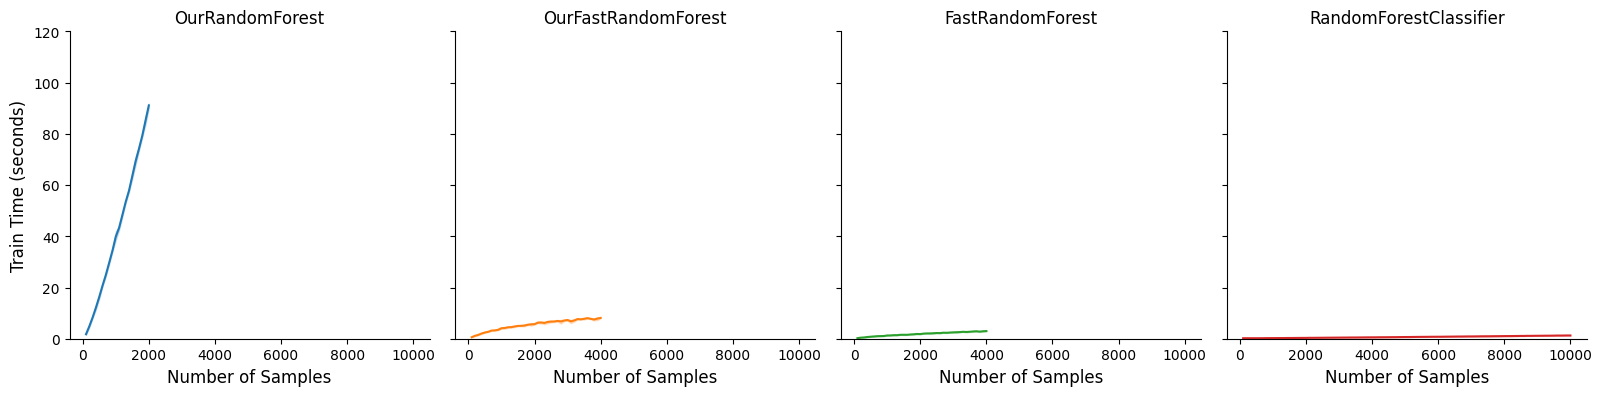

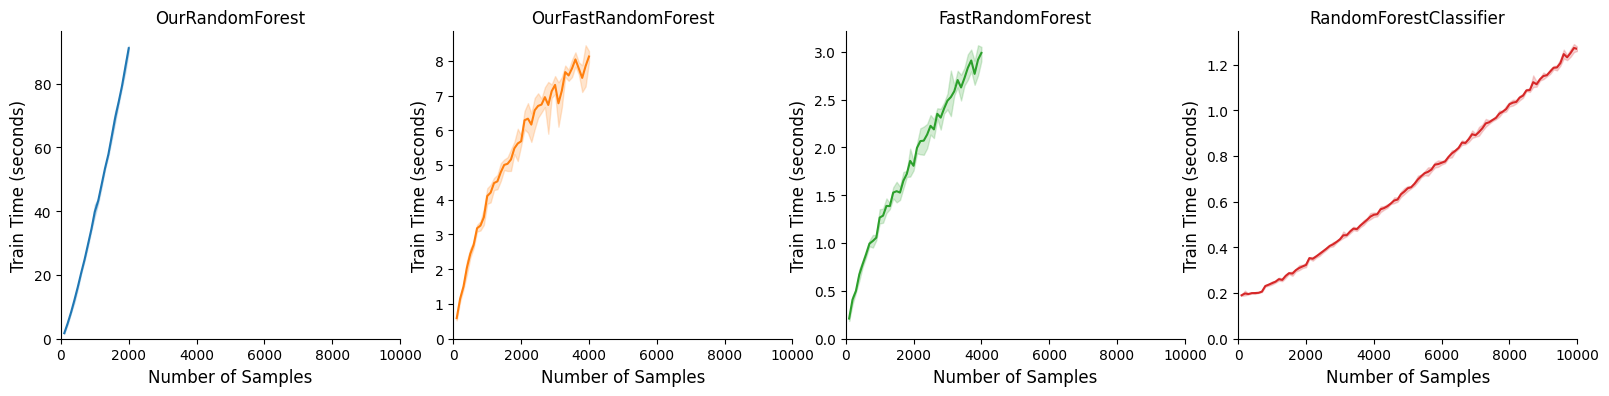

In [132]:
import seaborn as sns

results = pd.concat([pd.read_csv('results/results_v22.csv'), pd.read_csv('results/results_v22e.csv'), pd.read_csv('results/results_v22ef.csv')], ignore_index=True)
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_samples', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Train Time (seconds)')
    ax.set_xlabel('Number of Samples')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))
g.axes.flatten()[0].set_ylim(0, 120)


g = sns.FacetGrid(data = results, col='implementation', sharey='col', height=4, hue='implementation')
g.map(sns.lineplot, 'n_samples', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Train Time (seconds)')
    ax.set_xlabel('Number of Samples')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))
g.axes[0][3].set_xlim(0, 10000)

In [130]:
g.axes[1][3].set_xlim(0, 10000)

IndexError: index 1 is out of bounds for axis 0 with size 1

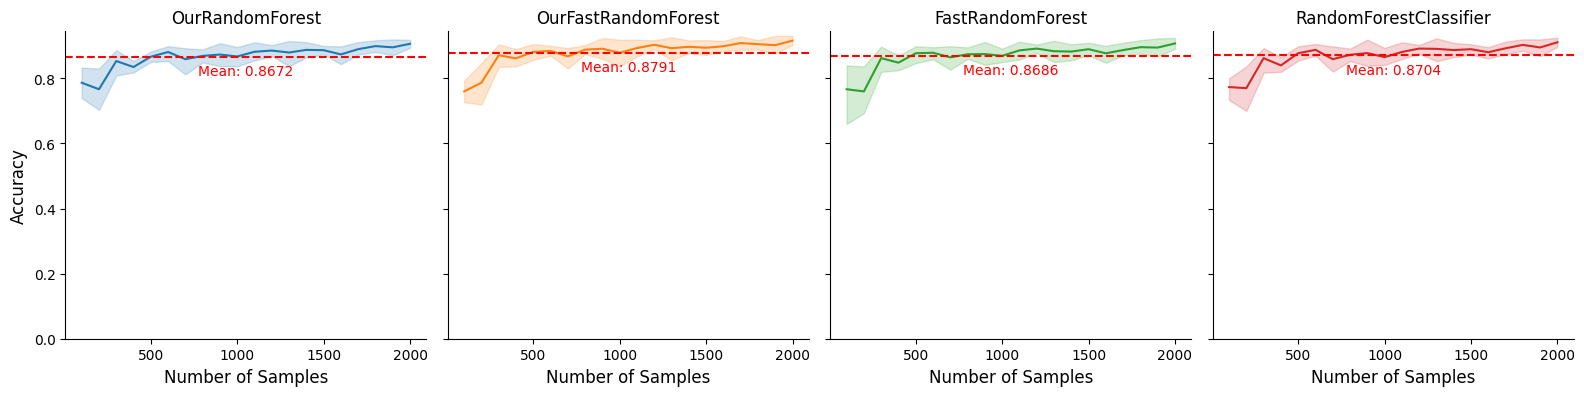

In [113]:
results = pd.concat([pd.read_csv('results/results_v22.csv')])
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_samples', "accuracy")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of Samples')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))

#Plota o valor médio de acurácia em cada axis
for ax in g.axes.flatten():
    impl = ax.get_title().replace('implementation = ', '')
    mean_acc = results[results['implementation'] == impl]['accuracy'].mean()
    ax.axhline(mean_acc, ls='--', color='red')
    #plot o valor médio como texto
    ax.text(0.5, mean_acc + -0.065, f'Mean: {mean_acc:.4f}', color='red', ha='center', va='bottom', transform=ax.get_yaxis_transform())


### Variando Número de Features

In [93]:
final = None

features_interval = range(20,501,20)
samples_interval = range(100, 101)
n_tests = range(5)
n_jobs = 12

tests = [{"features": features_interval, "samples": samples_interval, "n_test":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
shuffle = True
if shuffle:
    np.random.shuffle(tests)

for test in tqdm(tests):
    features = test["features"]
    samples = test["samples"]
    n_test = test["n_test"]
    # Create syntetic dataset using scikit
    data = make_classification(n_samples=samples, n_features=features, n_informative=int(features*0.5), n_redundant=int(features*0.25), n_clusters_per_class=2, random_state=n_test,)
    X, y = data
    results = [benchmark_rf(OurRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(OurFastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(FastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(RandomForestClassifier(n_estimators=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1)
            ]

    final = pd.concat([final] + results, ignore_index=True)

  0%|          | 0/125 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
final.to_csv('results/results_v23.csv', index=False)

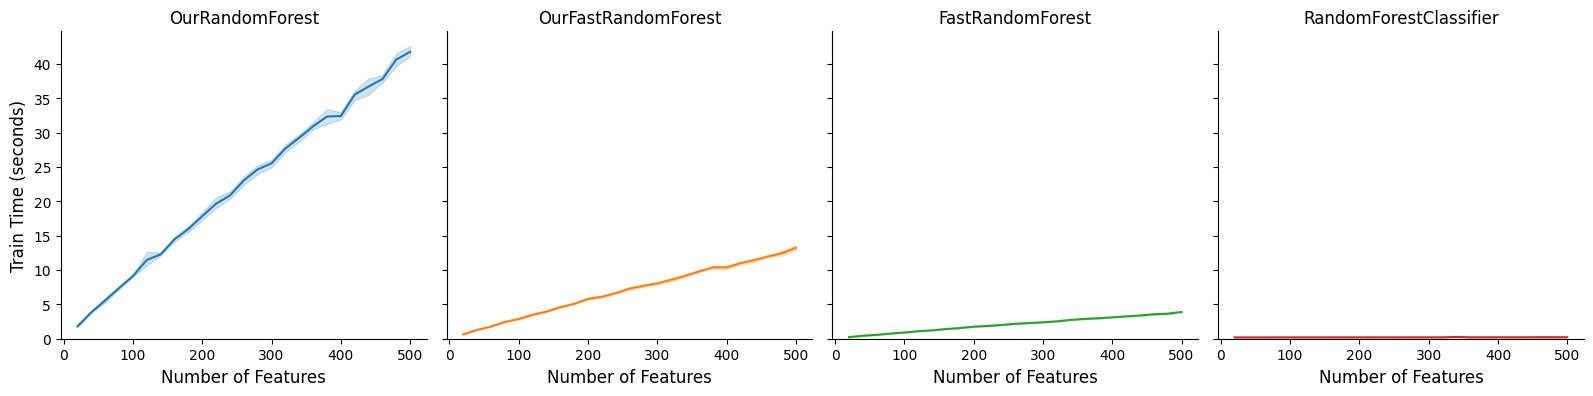

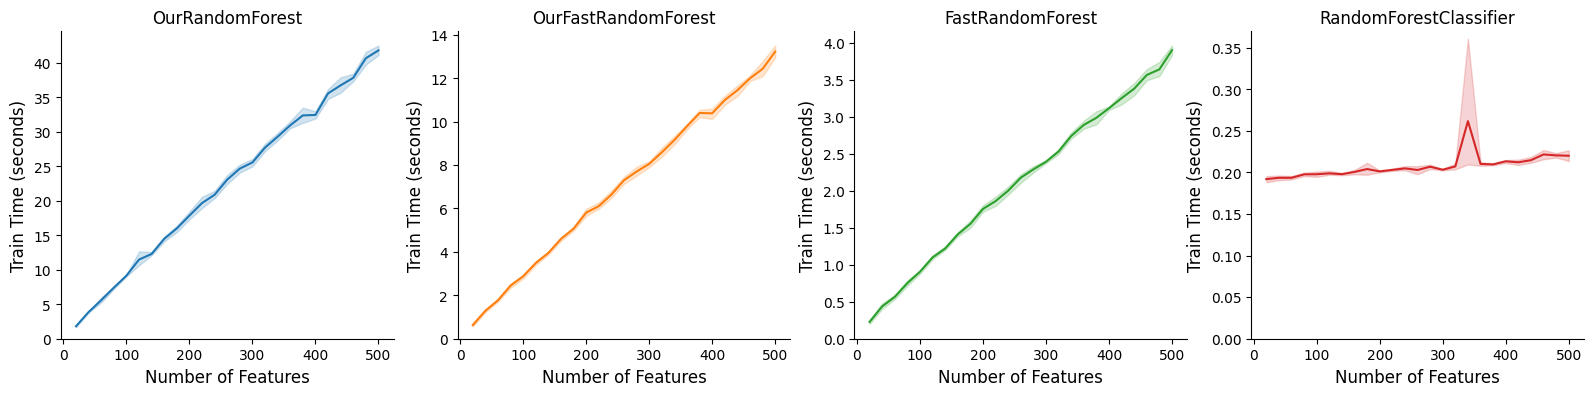

In [ ]:
import seaborn as sns

results = pd.concat([pd.read_csv('results/results_v23.csv')])
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Train Time (seconds)')
    ax.set_xlabel('Number of Features')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))

#set all font sizes



g = sns.FacetGrid(data = results, col='implementation', sharey='col', height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Train Time (seconds)')
    ax.set_xlabel('Number of Features')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))

### All Features vs sqrt(Features)

In [76]:
final = None

features_interval = range(20,1001,20)
samples_interval = range(100, 101)
n_tests = range(5)
n_jobs = 12

tests = [{"features": features_interval, "samples": samples_interval, "n_test":n_test} for features_interval, samples_interval, n_test in list(itertools.product(features_interval, samples_interval, n_tests))]
shuffle = True
if shuffle:
    np.random.shuffle(tests)

for test in tqdm(tests):
    features = test["features"]
    samples = test["samples"]
    n_test = test["n_test"]
    # Create syntetic dataset using scikit
    data = make_classification(n_samples=samples, n_features=features, n_informative=int(features*0.5), n_redundant=int(features*0.25), n_clusters_per_class=2, random_state=n_test,)
    X, y = data
    results = [benchmark_rf(FastRandomForest(n_trees=100, max_depth=7, max_features=None, n_jobs=n_jobs), X, y, n_tests=1),
               benchmark_rf(FastRandomForest(n_trees=100, max_depth=7, max_features='sqrt', n_jobs=n_jobs), X, y, n_tests=1),
            ]

    final = pd.concat([final] + results, ignore_index=True)

100%|██████████| 250/250 [17:15<00:00,  4.14s/it]


In [77]:
final.to_csv('results/results_v25.csv', index=False)

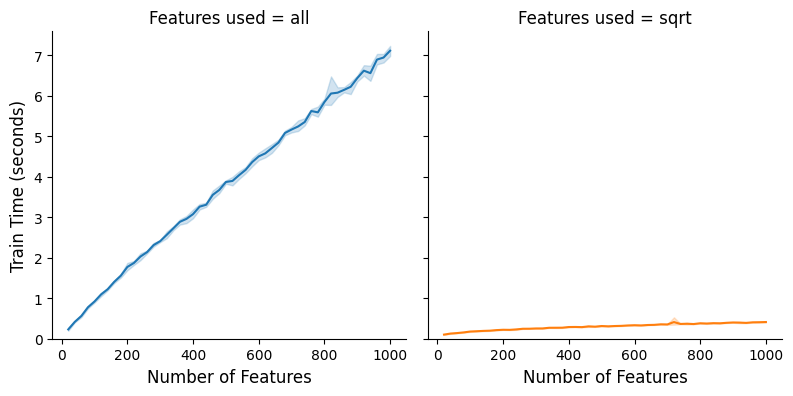

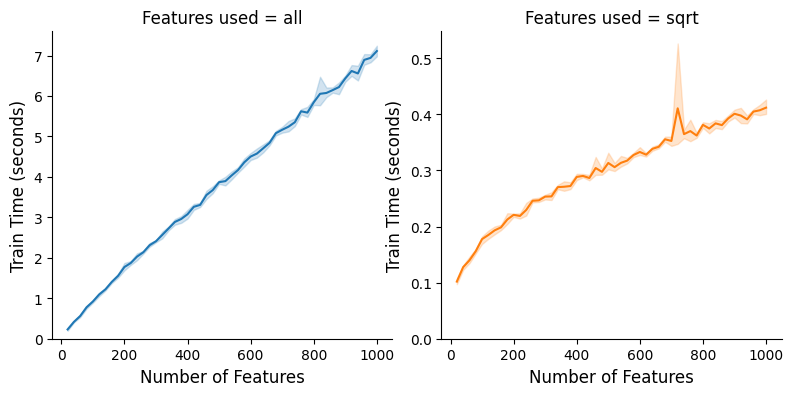

In [116]:
import seaborn as sns

final = pd.read_csv('results/results_v25.csv')
final['Features used'] = pd.Series(list(final.index)).apply(lambda x: 'sqrt' if x % 2 == 1 else 'all')
results = final
g = sns.FacetGrid(data = results, col='Features used', sharey=True, height=4, hue='Features used')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Train Time (seconds)')
    ax.set_xlabel('Number of Features')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))

#set all font sizes



g = sns.FacetGrid(data = results, col='Features used', sharey='col', height=4, hue='Features used')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Train Time (seconds)')
    ax.set_xlabel('Number of Features')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))

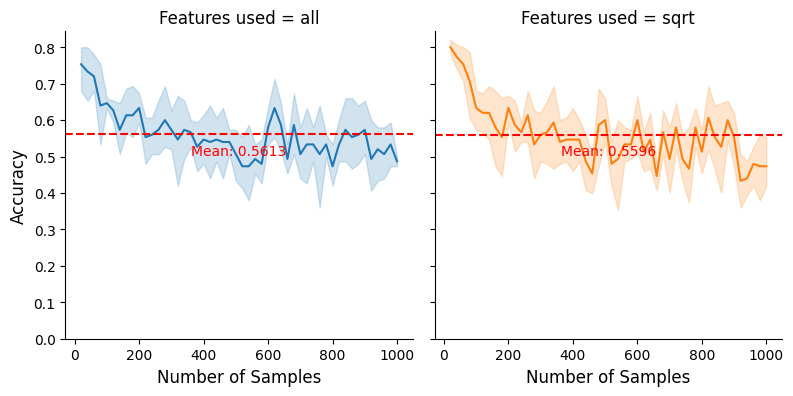

In [117]:
results = final
g = sns.FacetGrid(data = results, col='Features used', sharey=True, height=4, hue='Features used')
g.map(sns.lineplot, 'n_features', "accuracy")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of Samples')
    ax.title.set_size(12)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.set_title((ax.get_title().replace('implementation = ', '')))

#Plota o valor médio de acurácia em cada axis
for ax in g.axes.flatten():
    impl = ax.get_title().replace('Features used = ', '')
    mean_acc = results[results['Features used'] == impl]['accuracy'].mean()
    ax.axhline(mean_acc, ls='--', color='red')
    #plot o valor médio como texto
    ax.text(0.5, mean_acc + -0.065, f'Mean: {mean_acc:.4f}', color='red', ha='center', va='bottom', transform=ax.get_yaxis_transform())

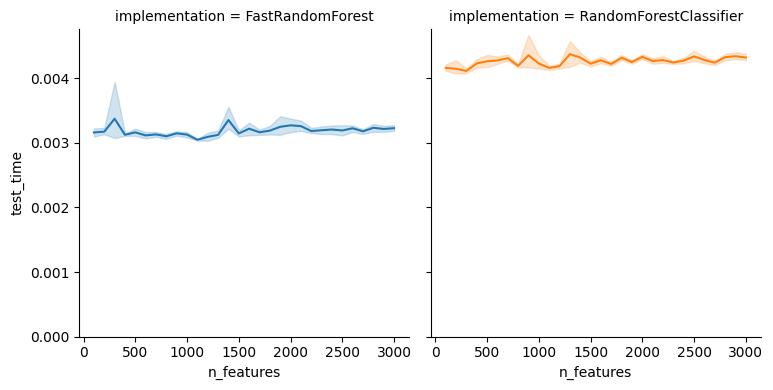

In [ ]:
import seaborn as sns

g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features',"test_time")

for ax in g.axes.flatten():
    ax.set_ylim(bottom=0.0)

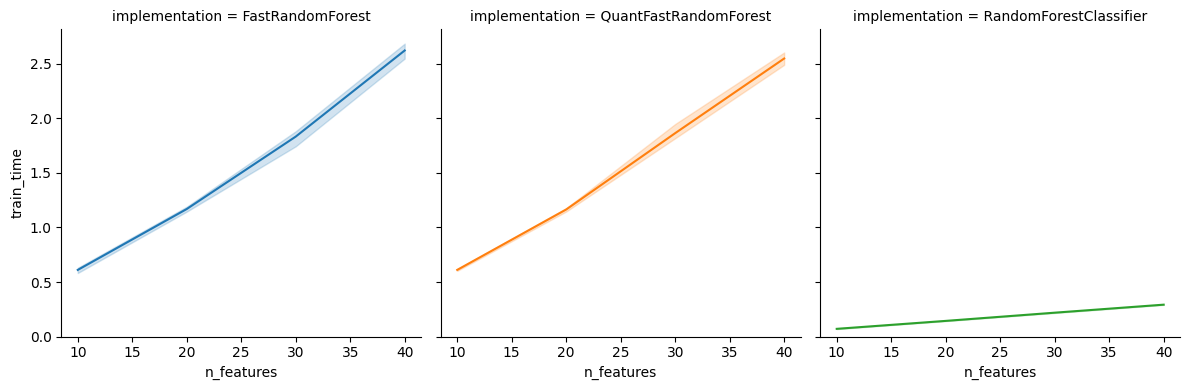

In [ ]:
import seaborn as sns

results = pd.read_csv('results/results_v08.csv')
g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)
